In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import os
from IPython.display import clear_output

In [2]:
CUBLAS_NAME = "cuBLAS"
algo_map = {
    2: CUBLAS_NAME,
    3: "cuSPARSE",
    7: "MACKO",
}

In [3]:
dasp_results_base = "../../DASP/dasp_results_16bit"
sputnik_results_base = "../../SpInfer/kernel_benchmark/sputnik_results_16bit"

In [4]:
def load_results(gpu_name, bits=16):
    path = f"../c_benchmarking/results_{bits}bit/{gpu_name}/results.txt"
    df = pd.read_csv(path, sep="\t", skiprows=1, index_col=None, names=["","Bits per value", "Rows", "Cols", "Algorithm", "Density", "Runtime", "GFLOPS", "Sparse GFLOPS"])
    df.loc[df["Runtime"]==" ", "Runtime"] = None
    df["Runtime"] = df["Runtime"].astype(float)
    df["Algorithm"] = df["Algorithm"].map(algo_map)

    dasp_path = os.path.join(dasp_results_base, gpu_name, "results.txt")
    if os.path.exists(dasp_path):
        dasp_df = pd.read_csv(
            dasp_path, sep="\t",
            skiprows=1, index_col=None, names=["","Bits per value", "Rows", "Cols", "Algorithm", "Density", "Runtime", "GFLOPS", "Sparse GFLOPS"])
        df = pd.concat([df, dasp_df]).reset_index()

    sputnik_path = os.path.join(sputnik_results_base, gpu_name, "sputnik_performance_results.csv")
    if os.path.exists(sputnik_path):
        sputnik_df_raw = pd.read_csv(sputnik_path)
        sputnik_df = pd.DataFrame({
            "Bits per value":16, 
            "Rows":sputnik_df_raw["M"],
            "Cols":sputnik_df_raw["K"],
            "Algorithm":sputnik_df_raw["Kernel"],
            "Density": (100-sputnik_df_raw["Sparsity"])/100,
            "Runtime": (sputnik_df_raw["Duration(ns)"]/1000).round(),
            "GFLOPS": (2*sputnik_df_raw["M"]*sputnik_df_raw["K"])/sputnik_df_raw["Duration(ns)"],
        })
        sputnik_df["GFLOPS"] = (sputnik_df["Rows"]*sputnik_df["Cols"])/(sputnik_df["Runtime"]*1000)
        sputnik_df["Sparse GFLOPS"] = (2*sputnik_df["Rows"]*sputnik_df["Cols"]*sputnik_df["Density"])/(sputnik_df["Runtime"]*1000)
        df = pd.concat([df, sputnik_df]).reset_index()

    df = df[df["Algorithm"]!="DASP2"]
    df = df[df["Algorithm"]!="DASPcuSPARSE"]

    return df


In [5]:
paper_path = "../../macko_spmv_paper"

In [6]:
def draw_speedup(full_df, gpu_name, size, to_paper=False):
    gpu_name_nice = gpu_name.replace("_", " ")

    R, C = size
    df = full_df[full_df['Algorithm'].isin([CUBLAS_NAME, "MACKO", "cuSPARSE", "Sputnik"])]

    for_m = df.query(f"Rows=={R} and Cols=={C}").copy()
    cublas_runtimes = for_m.query(f"Algorithm=='{CUBLAS_NAME}'")[["Runtime", "Density"]]
    cublas_runtime = cublas_runtimes["Runtime"].mean()
    for_m = pd.merge(for_m, cublas_runtimes, how="left", on="Density", suffixes=("","_cublas"))
    for_m["Speedup over cuBLAS"] = for_m["Runtime_cublas"]/for_m["Runtime"]
    for_m["Sparsity"] = (1-for_m["Density"]).round(2)
    for_m["Density"] = for_m["Density"]

    ax = sns.lineplot(data=for_m, x="Sparsity", y="Speedup over cuBLAS", hue="Algorithm")

    cublas_color = [line.get_color() for line in ax.lines if line.get_label().strip() == CUBLAS_NAME][0]

    for line in ax.lines:
        # Get the data of this line
        x_data = line.get_xdata()
        y_data = line.get_ydata()
        if line.get_color() == cublas_color:
            continue
        
        for x, y in zip(x_data, y_data):
            ax.text(
                x, y,
                f'{y:.2f}',          # format label
                color="black",
                fontsize=9,
                ha='center',         # horizontal alignment
                va='bottom'          # vertical alignment
            )

    plt.xticks([0.1*x for x in range(11)])
    plt.grid(linestyle=":", alpha=0.5)
    title = f"{gpu_name_nice}, fp16, {R}x{C}, cuBLAS runtime {int(cublas_runtime)} $\\mu s$"

    if not to_paper:
        plt.title(title)
    print(title)
    if to_paper:
        plt.savefig(os.path.join(paper_path, f"paper/fp16_{gpu_name}_{R}_{C}_relative_speedup.pdf"))
    else:
        plt.savefig(f"../media/fp16_{gpu_name}_{R}_{C}_relative_speedup.svg")
        plt.savefig(f"../media/fp16_{gpu_name}_{R}_{C}_relative_speedup.png")

    plt.show()

In [7]:
def draw_speedup_bar(full_df, gpu_name, size, to_paper=False):
    gpu_name_nice = gpu_name.replace("_", " ")

    R, C = size
    df = full_df[full_df['Algorithm'].isin([CUBLAS_NAME, "MACKO", "cuSPARSE", "Sputnik", "DASP"])]

    for_m = df.query(f"Rows=={R} and Cols=={C}").copy()
    cublas_runtimes = for_m.query(f"Algorithm=='{CUBLAS_NAME}'")[["Runtime", "Density"]]
    cublas_runtime = cublas_runtimes["Runtime"].mean()
    for_m = pd.merge(for_m, cublas_runtimes, how="left", on="Density", suffixes=("","_cublas"))
    for_m["Speedup over cuBLAS"] = for_m["Runtime_cublas"]/for_m["Runtime"]
    for_m["Sparsity"] = (1-for_m["Density"]).round(2).apply(lambda x: f"{int(x*100)}%")
    for_m["Density"] = for_m["Density"]

    plt.figure(figsize=(12,4))
    ax = sns.barplot(data=for_m, x="Sparsity", y="Speedup over cuBLAS", hue="Algorithm")

    for container in ax.containers:
        ax.bar_label(container, fmt='  %.2f', label_type='edge', rotation=90, fontsize=8)

    plt.ylim(0, for_m["Speedup over cuBLAS"].max()+1.0)
    plt.grid(linestyle=":", alpha=0.5)
    title = f"{gpu_name_nice}, fp16, {R}x{C}, cuBLAS runtime {int(cublas_runtime)} $\\mu s$"

    if not to_paper:
        plt.title(title)
    print(title)
    paper_path_short = f"paper/fp16_{gpu_name}_{R}_{C}_relative_speedup.pdf"
    paper_graph_path = os.path.join(paper_path, paper_path_short)
    if to_paper:
        print(r""" 
\begin{figure}[H]
    \centering
    \includegraphics[width=\textwidth]{""" + paper_path_short + r"""}
    \caption{Speedup of MACKO relative to cuBLAS on """ + gpu_name_nice + """ for """+ f"{R}x{C}" + """, cuBLAS runtime """ + str(int(cublas_runtime)) + r""" $\mu s$.}
    \label{appendix_speedup:""" + f"{gpu_name}:{R}:{C}" + """}
\\end{figure}
""")

    if to_paper:
        plt.savefig(paper_graph_path, bbox_inches='tight')
    else:
        plt.savefig(f"../media/fp16_{gpu_name}_{R}_{C}_relative_speedup_bar.svg")
        #plt.savefig(f"../media/fp16_{gpu_name}_{R}_{C}_relative_speedup_bar.png")

    plt.show()


In [9]:
def draw_speedup_over_all_sizes(df, gpu_name, to_paper=False):
    gpu_name_nice = gpu_name.replace("_", " ")

    over_sizes = df.copy()
    speedups = []
    for i, row in over_sizes.iterrows():
        cublas_runtime = df.query(f"Rows=={row.Rows} and Cols=={row.Cols} and Density=={row.Density} and Algorithm=='{CUBLAS_NAME}'")["Runtime"].mean()
        speedup = cublas_runtime/row.Runtime
        speedups.append(speedup)


    over_sizes["Sparsity"] = (1-over_sizes["Density"]).round(2).apply(lambda x: f"{int(100*x)}%")
    over_sizes["Speedup over cuBLAS"] = speedups
    sns.boxplot(data=over_sizes, x="Sparsity", y="Speedup over cuBLAS", hue="Algorithm", fill=False, gap=.1)

    plt.grid(linestyle=":", alpha=0.5)

    title = f"{gpu_name_nice}, fp16"
    print(title)
    if not to_paper:
        plt.title(title)

    if to_paper:
        plt.savefig(os.path.join(paper_path, f"paper/{gpu_name}_relative_speedup_all_sizes.pdf"), bbox_inches='tight')
    else:
        plt.savefig(f"../media/{gpu_name}_relative_speedup_all_sizes.svg")
        #plt.savefig(f"../media/{gpu_name}_relative_speedup_all_sizes.png")

    plt.show()

    for d in ["0.1", "0.5"]:
        for algo in over_sizes.Algorithm.unique():
            df_d = over_sizes.query(f"Algorithm == '{algo}' and Density=={d}")
            print(f"Density {d} {algo}")
            display(df_d[["Rows", "Cols", "Speedup over cuBLAS"]].describe())


In [10]:
def print_speedup_over_baselines(df, densities):

    over_sizes = df.copy()
    speedups = []
    for _, row in over_sizes.iterrows():
        cublas_runtime = df.query(f"Rows=={row.Rows} and Cols=={row.Cols} and Density=={row.Density} and Algorithm=='{CUBLAS_NAME}'")["Runtime"].mean()
        speedup = cublas_runtime/row.Runtime
        speedups.append(speedup)


    over_sizes["Sparsity"] = (1-over_sizes["Density"]).round(2).apply(lambda x: f"{int(100*x)}%")
    over_sizes["Speedup over cuBLAS"] = speedups

    #metric = "mean"
    metric = "50%"
    for d in densities:
        tmp_df = over_sizes.query(f"Algorithm == 'MACKO' and Density=={d}")[["Speedup over cuBLAS"]].describe()
        macko = tmp_df.loc[metric].iloc[0]

        for algo in over_sizes.Algorithm.unique():
            tmp_df = over_sizes.query(f"Algorithm == '{algo}' and Density=={d}")[["Speedup over cuBLAS"]].describe()
            m = tmp_df.loc[metric]
            print(f"Density {d} {algo} {m.iloc[0]} {macko/m.iloc[0]}")
            display()


In [17]:
headline_df

,level_0,index,,Bits per value,Rows,Cols,Algorithm,Density,Runtime,GFLOPS,Sparse GFLOPS,Sparsity
891,891,891.0,Final results:,16,36864,12288,cuBLAS,1.00,951.000000,952.000000,952.000000,0.0
892,892,892.0,Final results:,16,36864,12288,cuBLAS,0.90,951.000000,952.000000,857.000000,10.0
893,893,893.0,Final results:,16,36864,12288,cuBLAS,0.80,951.000000,952.000000,761.000000,20.0
894,894,894.0,Final results:,16,36864,12288,cuBLAS,0.70,951.000000,952.000000,666.000000,30.0
895,895,895.0,Final results:,16,36864,12288,cuBLAS,0.60,951.000000,952.000000,571.000000,40.0
896,896,896.0,Final results:,16,36864,12288,cuBLAS,0.50,951.000000,952.000000,476.000000,50.0
897,897,897.0,Final results:,16,36864,12288,cuBLAS,0.40,950.000000,952.000000,381.000000,60.0
898,898,898.0,Final results:,16,36864,12288,cuBLAS,0.30,951.000000,952.000000,285.000000,70.0
899,899,899.0,Final results:,16,36864,12288,cuBLAS,0.20,951.000000,952.000000,190.000000,80.0
900,900,900.0,Final results:,16,36864,12288,cuBLAS,0.10,951.000000,952.000000,95.000000,90.0


In [139]:
from shapely.geometry import Polygon
import numpy as np

def draw_headline(target_gpu, R, C, points):
    #Rows 36864 Columns 12288
    headline_df = load_results(target_gpu).query(f"Rows=={R} and Cols=={C}")
    headline_df["Sparsity"] = (1-headline_df["Density"])*100
    cublas_time = headline_df.query("Algorithm == 'cuBLAS'")["Runtime"].mean()
    sns.lineplot(headline_df, y="Runtime", x="Sparsity", hue="Algorithm")
    plt.xticks([10*x for x in range(11)])
    plt.ylabel("Runtime [$\\mu s$]")
    plt.xlabel("Sparsiy [%]")
    plt.grid(linestyle=":", alpha=0.5)
    plt.ylim(0, 1500)

    macko_polygon = Polygon(np.concat((
        headline_df.query("Algorithm=='MACKO'")[["Sparsity","Runtime"]].values,
        [[100, 200000]],
        [[0, 200000]]
    )))
    sputnik_polygon = Polygon(np.concat((
        headline_df.query("Algorithm=='Sputnik'")[["Sparsity","Runtime"]].values,
        [[100, 0]],
        [[0, 0]]
    )))
    cublas_polygon = Polygon(np.concat((
        headline_df.query("Algorithm=='cuBLAS'")[["Sparsity","Runtime"]].values,
        [[100, 0]],
        [[0, 0]]
    )))

    best_baseline = sputnik_polygon.intersection(cublas_polygon)
    improvemetnt = macko_polygon.intersection(best_baseline)

    plt.fill(improvemetnt.exterior.xy[0], improvemetnt.exterior.xy[1], hatch="//", facecolor="w", edgecolor='tab:olive')

    for sp, offset in points:
        plt.annotate(f"{sp}%", (sp, cublas_time), xytext=(sp+5 + offset, cublas_time + 150), arrowprops=dict(facecolor='black', arrowstyle='->'),  # arrow style
            fontsize=10,
        )



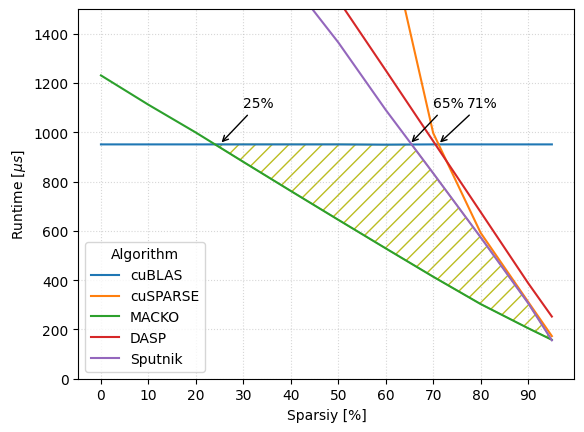

In [141]:
R, C = 36864, 12288
target_gpu = "NVIDIA_GeForce_RTX_4090"
points = [(25,0), (65,0), (71, 1)]
draw_headline(target_gpu, R, C, points)
plt.savefig(os.path.join(paper_path, f"paper/{target_gpu }_gain_over_baselines.pdf"), bbox_inches='tight')


In [10]:
for target_gpu in ["NVIDIA_GeForce_RTX_4090", "NVIDIA_GeForce_RTX_3090", "NVIDIA_GeForce_RTX_2080_SUPER"]:
    print(target_gpu)
    df = load_results(target_gpu)
    print_speedup_over_baselines(df, ["0.5"])

NVIDIA_GeForce_RTX_4090
Density 0.5 cuBLAS 1.0 1.3333333333333333
Density 0.5 cuSPARSE 0.4665127020785219 2.8580858085808583
Density 0.5 MACKO 1.3333333333333333 1.0
Density 0.5 DASP 0.5906861826287336 2.257261761904762
Density 0.5 Sputnik 0.6691729323308271 1.99250936329588
NVIDIA_GeForce_RTX_3090
Density 0.5 cuBLAS 1.0 1.4772727272727273
Density 0.5 cuSPARSE 0.11332007952286283 13.036283891547049
Density 0.5 MACKO 1.4772727272727273 1.0
Density 0.5 DASP 0.6070739558615191 2.4334312368519906
Density 0.5 Sputnik 0.7258064516129032 2.0353535353535355
NVIDIA_GeForce_RTX_2080_SUPER
Density 0.5 cuBLAS 1.0 1.4941176470588236
Density 0.5 cuSPARSE 0.25806451612903225 5.7897058823529415
Density 0.5 MACKO 1.4941176470588236 1.0
Density 0.5 DASP 0.5970875041595417 2.5023428503363814
Density 0.5 Sputnik 0.5754098360655737 2.5966147142617735


NVIDIA GeForce RTX 4090, fp16


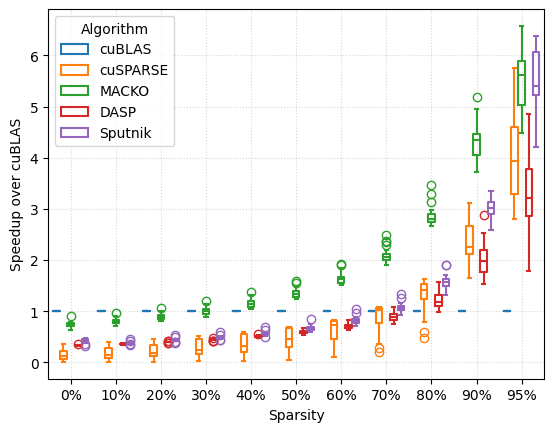

Density 0.1 cuBLAS


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.0
mean,16631.741935,12936.258065,1.0
std,12519.679738,11009.633887,0.0
min,3584.000000,3584.000000,1.0
25%,7168.000000,5120.000000,1.0
50%,12288.000000,9216.000000,1.0
75%,28160.000000,14080.000000,1.0
max,49152.000000,49152.000000,1.0


Density 0.1 cuSPARSE


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,2.399839
std,12519.679738,11009.633887,0.375166
min,3584.000000,3584.000000,1.641533
25%,7168.000000,5120.000000,2.113481
50%,12288.000000,9216.000000,2.246753
75%,28160.000000,14080.000000,2.670198
max,49152.000000,49152.000000,3.113861


Density 0.1 MACKO


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,4.307942
std,12519.679738,11009.633887,0.302822
min,3584.000000,3584.000000,3.727273
25%,7168.000000,5120.000000,4.053559
50%,12288.000000,9216.000000,4.339806
75%,28160.000000,14080.000000,4.457801
max,49152.000000,49152.000000,5.187500


Density 0.1 DASP


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,2.004799
std,12519.679738,11009.633887,0.313842
min,3584.000000,3584.000000,1.534139
25%,7168.000000,5120.000000,1.761330
50%,12288.000000,9216.000000,1.985323
75%,28160.000000,14080.000000,2.187860
max,49152.000000,49152.000000,2.877832


Density 0.1 Sputnik


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,3.004418
std,12519.679738,11009.633887,0.194893
min,3584.000000,3584.000000,2.584615
25%,7168.000000,5120.000000,2.900013
50%,12288.000000,9216.000000,3.025210
75%,28160.000000,14080.000000,3.132053
max,49152.000000,49152.000000,3.340000


Density 0.5 cuBLAS


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.0
mean,16631.741935,12936.258065,1.0
std,12519.679738,11009.633887,0.0
min,3584.000000,3584.000000,1.0
25%,7168.000000,5120.000000,1.0
50%,12288.000000,9216.000000,1.0
75%,28160.000000,14080.000000,1.0
max,49152.000000,49152.000000,1.0


Density 0.5 cuSPARSE


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,0.446823
std,12519.679738,11009.633887,0.214834
min,3584.000000,3584.000000,0.053229
25%,7168.000000,5120.000000,0.302468
50%,12288.000000,9216.000000,0.466513
75%,28160.000000,14080.000000,0.671034
max,49152.000000,49152.000000,0.689655


Density 0.5 MACKO


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,1.353817
std,12519.679738,11009.633887,0.090849
min,3584.000000,3584.000000,1.231707
25%,7168.000000,5120.000000,1.286889
50%,12288.000000,9216.000000,1.333333
75%,28160.000000,14080.000000,1.389436
max,49152.000000,49152.000000,1.594595


Density 0.5 DASP


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,0.592003
std,12519.679738,11009.633887,0.027531
min,3584.000000,3584.000000,0.537844
25%,7168.000000,5120.000000,0.573474
50%,12288.000000,9216.000000,0.590686
75%,28160.000000,14080.000000,0.611357
max,49152.000000,49152.000000,0.665262


Density 0.5 Sputnik


,Rows,Cols,Speedup over cuBLAS
count,32.000000,32.000000,31.000000
mean,16239.875000,12659.875000,0.667017
std,12513.995571,10942.868716,0.051262
min,3584.000000,3584.000000,0.591133
25%,6656.000000,5120.000000,0.639535
50%,11648.000000,8704.000000,0.669173
75%,27904.000000,13952.000000,0.691271
max,49152.000000,49152.000000,0.855072


NVIDIA GeForce RTX 3090, fp16


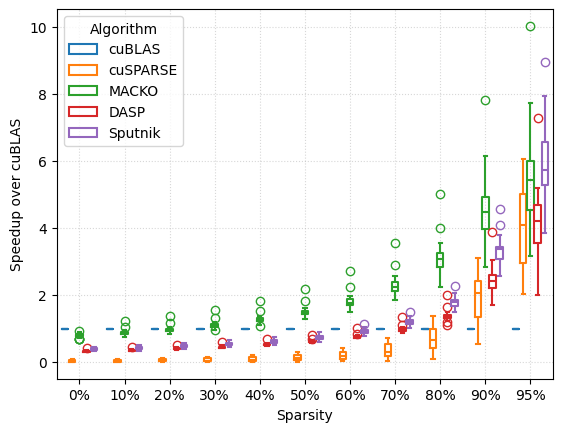

Density 0.1 cuBLAS


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.0
mean,16631.741935,12936.258065,1.0
std,12519.679738,11009.633887,0.0
min,3584.000000,3584.000000,1.0
25%,7168.000000,5120.000000,1.0
50%,12288.000000,9216.000000,1.0
75%,28160.000000,14080.000000,1.0
max,49152.000000,49152.000000,1.0


Density 0.1 cuSPARSE


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,1.888325
std,12519.679738,11009.633887,0.746920
min,3584.000000,3584.000000,0.552617
25%,7168.000000,5120.000000,1.341133
50%,12288.000000,9216.000000,2.061224
75%,28160.000000,14080.000000,2.408647
max,49152.000000,49152.000000,3.102564


Density 0.1 MACKO


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,4.509329
std,12519.679738,11009.633887,0.922362
min,3584.000000,3584.000000,2.842105
25%,7168.000000,5120.000000,3.958546
50%,12288.000000,9216.000000,4.472000
75%,28160.000000,14080.000000,4.933966
max,49152.000000,49152.000000,7.814961


Density 0.1 DASP


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,2.415686
std,12519.679738,11009.633887,0.405934
min,3584.000000,3584.000000,1.701785
25%,7168.000000,5120.000000,2.201813
50%,12288.000000,9216.000000,2.431582
75%,28160.000000,14080.000000,2.593906
max,49152.000000,49152.000000,3.886870


Density 0.1 Sputnik


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,3.312788
std,12519.679738,11009.633887,0.395794
min,3584.000000,3584.000000,2.571429
25%,7168.000000,5120.000000,3.079950
50%,12288.000000,9216.000000,3.362069
75%,28160.000000,14080.000000,3.441642
max,49152.000000,49152.000000,4.552752


Density 0.5 cuBLAS


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.0
mean,16631.741935,12936.258065,1.0
std,12519.679738,11009.633887,0.0
min,3584.000000,3584.000000,1.0
25%,7168.000000,5120.000000,1.0
50%,12288.000000,9216.000000,1.0
75%,28160.000000,14080.000000,1.0
max,49152.000000,49152.000000,1.0


Density 0.5 cuSPARSE


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,0.125422
std,12519.679738,11009.633887,0.093027
min,3584.000000,3584.000000,0.016363
25%,7168.000000,5120.000000,0.048203
50%,12288.000000,9216.000000,0.113320
75%,28160.000000,14080.000000,0.206517
max,49152.000000,49152.000000,0.288820


Density 0.5 MACKO


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,1.490779
std,12519.679738,11009.633887,0.166093
min,3584.000000,3584.000000,1.295455
25%,7168.000000,5120.000000,1.430252
50%,12288.000000,9216.000000,1.477273
75%,28160.000000,14080.000000,1.537600
max,49152.000000,49152.000000,2.176535


Density 0.5 DASP


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,0.618799
std,12519.679738,11009.633887,0.045451
min,3584.000000,3584.000000,0.575980
25%,7168.000000,5120.000000,0.590498
50%,12288.000000,9216.000000,0.607074
75%,28160.000000,14080.000000,0.628246
max,49152.000000,49152.000000,0.818463


Density 0.5 Sputnik


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,0.733433
std,12519.679738,11009.633887,0.061900
min,3584.000000,3584.000000,0.612624
25%,7168.000000,5120.000000,0.695387
50%,12288.000000,9216.000000,0.725806
75%,28160.000000,14080.000000,0.780018
max,49152.000000,49152.000000,0.890934


NVIDIA GeForce RTX 2080 SUPER, fp16


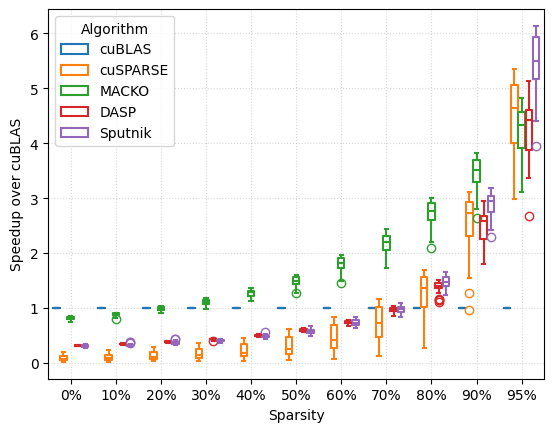

Density 0.1 cuBLAS


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.0
mean,16631.741935,12936.258065,1.0
std,12519.679738,11009.633887,0.0
min,3584.000000,3584.000000,1.0
25%,7168.000000,5120.000000,1.0
50%,12288.000000,9216.000000,1.0
75%,28160.000000,14080.000000,1.0
max,49152.000000,49152.000000,1.0


Density 0.1 cuSPARSE


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,2.545674
std,12519.679738,11009.633887,0.593534
min,3584.000000,3584.000000,0.958899
25%,7168.000000,5120.000000,2.309722
50%,12288.000000,9216.000000,2.736771
75%,28160.000000,14080.000000,2.934568
max,49152.000000,49152.000000,3.119149


Density 0.1 MACKO


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,3.437532
std,12519.679738,11009.633887,0.300251
min,3584.000000,3584.000000,2.636364
25%,7168.000000,5120.000000,3.289617
50%,12288.000000,9216.000000,3.506849
75%,28160.000000,14080.000000,3.693647
max,49152.000000,49152.000000,3.823383


Density 0.1 DASP


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,2.479330
std,12519.679738,11009.633887,0.329412
min,3584.000000,3584.000000,1.808103
25%,7168.000000,5120.000000,2.257176
50%,12288.000000,9216.000000,2.581515
75%,28160.000000,14080.000000,2.673591
max,49152.000000,49152.000000,2.947197


Density 0.1 Sputnik


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,2.874799
std,12519.679738,11009.633887,0.253700
min,3584.000000,3584.000000,2.289474
25%,7168.000000,5120.000000,2.750968
50%,12288.000000,9216.000000,2.954545
75%,28160.000000,14080.000000,3.032400
max,49152.000000,49152.000000,3.186957


Density 0.5 cuBLAS


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.0
mean,16631.741935,12936.258065,1.0
std,12519.679738,11009.633887,0.0
min,3584.000000,3584.000000,1.0
25%,7168.000000,5120.000000,1.0
50%,12288.000000,9216.000000,1.0
75%,28160.000000,14080.000000,1.0
max,49152.000000,49152.000000,1.0


Density 0.5 cuSPARSE


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,0.297097
std,12519.679738,11009.633887,0.178717
min,3584.000000,3584.000000,0.047417
25%,7168.000000,5120.000000,0.169597
50%,12288.000000,9216.000000,0.258065
75%,28160.000000,14080.000000,0.478784
max,49152.000000,49152.000000,0.617391


Density 0.5 MACKO


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,1.480932
std,12519.679738,11009.633887,0.096345
min,3584.000000,3584.000000,1.264706
25%,7168.000000,5120.000000,1.441654
50%,12288.000000,9216.000000,1.494118
75%,28160.000000,14080.000000,1.554791
max,49152.000000,49152.000000,1.601810


Density 0.5 DASP


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,0.599665
std,12519.679738,11009.633887,0.020572
min,3584.000000,3584.000000,0.559736
25%,7168.000000,5120.000000,0.585581
50%,12288.000000,9216.000000,0.597088
75%,28160.000000,14080.000000,0.613588
max,49152.000000,49152.000000,0.638114


Density 0.5 Sputnik


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,0.581437
std,12519.679738,11009.633887,0.044541
min,3584.000000,3584.000000,0.489712
25%,7168.000000,5120.000000,0.547092
50%,12288.000000,9216.000000,0.575410
75%,28160.000000,14080.000000,0.607099
max,49152.000000,49152.000000,0.672878


In [11]:
for target_gpu in ["NVIDIA_GeForce_RTX_4090", "NVIDIA_GeForce_RTX_3090", "NVIDIA_GeForce_RTX_2080_SUPER"]:
    df = load_results(target_gpu)
    draw_speedup_over_all_sizes(df, target_gpu, to_paper=True)

NVIDIA GeForce RTX 4090, fp16


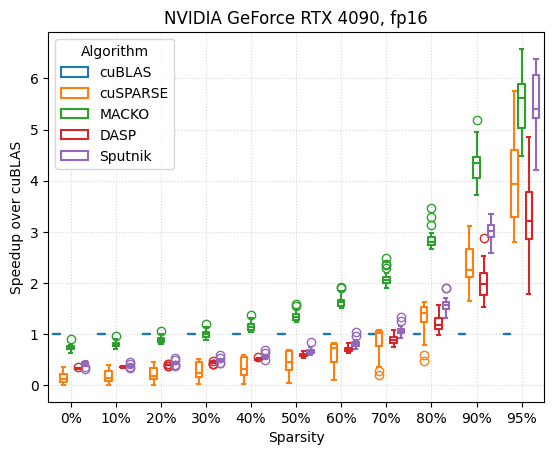

Density 0.1 cuBLAS


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.0
mean,16631.741935,12936.258065,1.0
std,12519.679738,11009.633887,0.0
min,3584.000000,3584.000000,1.0
25%,7168.000000,5120.000000,1.0
50%,12288.000000,9216.000000,1.0
75%,28160.000000,14080.000000,1.0
max,49152.000000,49152.000000,1.0


Density 0.1 cuSPARSE


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,2.399839
std,12519.679738,11009.633887,0.375166
min,3584.000000,3584.000000,1.641533
25%,7168.000000,5120.000000,2.113481
50%,12288.000000,9216.000000,2.246753
75%,28160.000000,14080.000000,2.670198
max,49152.000000,49152.000000,3.113861


Density 0.1 MACKO


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,4.307942
std,12519.679738,11009.633887,0.302822
min,3584.000000,3584.000000,3.727273
25%,7168.000000,5120.000000,4.053559
50%,12288.000000,9216.000000,4.339806
75%,28160.000000,14080.000000,4.457801
max,49152.000000,49152.000000,5.187500


Density 0.1 DASP


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,2.004799
std,12519.679738,11009.633887,0.313842
min,3584.000000,3584.000000,1.534139
25%,7168.000000,5120.000000,1.761330
50%,12288.000000,9216.000000,1.985323
75%,28160.000000,14080.000000,2.187860
max,49152.000000,49152.000000,2.877832


Density 0.1 Sputnik


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,3.004418
std,12519.679738,11009.633887,0.194893
min,3584.000000,3584.000000,2.584615
25%,7168.000000,5120.000000,2.900013
50%,12288.000000,9216.000000,3.025210
75%,28160.000000,14080.000000,3.132053
max,49152.000000,49152.000000,3.340000


Density 0.5 cuBLAS


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.0
mean,16631.741935,12936.258065,1.0
std,12519.679738,11009.633887,0.0
min,3584.000000,3584.000000,1.0
25%,7168.000000,5120.000000,1.0
50%,12288.000000,9216.000000,1.0
75%,28160.000000,14080.000000,1.0
max,49152.000000,49152.000000,1.0


Density 0.5 cuSPARSE


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,0.446823
std,12519.679738,11009.633887,0.214834
min,3584.000000,3584.000000,0.053229
25%,7168.000000,5120.000000,0.302468
50%,12288.000000,9216.000000,0.466513
75%,28160.000000,14080.000000,0.671034
max,49152.000000,49152.000000,0.689655


Density 0.5 MACKO


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,1.353817
std,12519.679738,11009.633887,0.090849
min,3584.000000,3584.000000,1.231707
25%,7168.000000,5120.000000,1.286889
50%,12288.000000,9216.000000,1.333333
75%,28160.000000,14080.000000,1.389436
max,49152.000000,49152.000000,1.594595


Density 0.5 DASP


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,0.592003
std,12519.679738,11009.633887,0.027531
min,3584.000000,3584.000000,0.537844
25%,7168.000000,5120.000000,0.573474
50%,12288.000000,9216.000000,0.590686
75%,28160.000000,14080.000000,0.611357
max,49152.000000,49152.000000,0.665262


Density 0.5 Sputnik


,Rows,Cols,Speedup over cuBLAS
count,32.000000,32.000000,31.000000
mean,16239.875000,12659.875000,0.667017
std,12513.995571,10942.868716,0.051262
min,3584.000000,3584.000000,0.591133
25%,6656.000000,5120.000000,0.639535
50%,11648.000000,8704.000000,0.669173
75%,27904.000000,13952.000000,0.691271
max,49152.000000,49152.000000,0.855072


NVIDIA GeForce RTX 3090, fp16


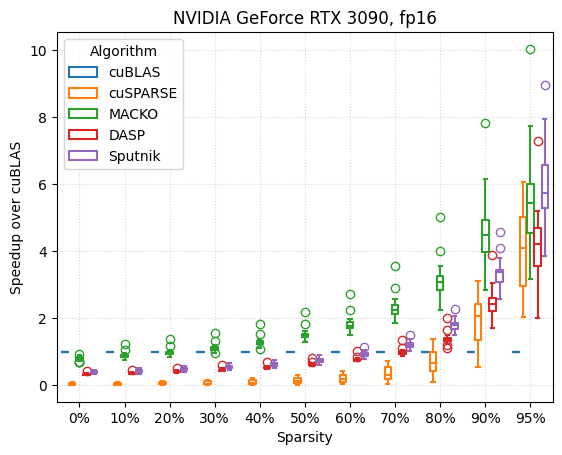

Density 0.1 cuBLAS


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.0
mean,16631.741935,12936.258065,1.0
std,12519.679738,11009.633887,0.0
min,3584.000000,3584.000000,1.0
25%,7168.000000,5120.000000,1.0
50%,12288.000000,9216.000000,1.0
75%,28160.000000,14080.000000,1.0
max,49152.000000,49152.000000,1.0


Density 0.1 cuSPARSE


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,1.888325
std,12519.679738,11009.633887,0.746920
min,3584.000000,3584.000000,0.552617
25%,7168.000000,5120.000000,1.341133
50%,12288.000000,9216.000000,2.061224
75%,28160.000000,14080.000000,2.408647
max,49152.000000,49152.000000,3.102564


Density 0.1 MACKO


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,4.509329
std,12519.679738,11009.633887,0.922362
min,3584.000000,3584.000000,2.842105
25%,7168.000000,5120.000000,3.958546
50%,12288.000000,9216.000000,4.472000
75%,28160.000000,14080.000000,4.933966
max,49152.000000,49152.000000,7.814961


Density 0.1 DASP


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,2.415686
std,12519.679738,11009.633887,0.405934
min,3584.000000,3584.000000,1.701785
25%,7168.000000,5120.000000,2.201813
50%,12288.000000,9216.000000,2.431582
75%,28160.000000,14080.000000,2.593906
max,49152.000000,49152.000000,3.886870


Density 0.1 Sputnik


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,3.312788
std,12519.679738,11009.633887,0.395794
min,3584.000000,3584.000000,2.571429
25%,7168.000000,5120.000000,3.079950
50%,12288.000000,9216.000000,3.362069
75%,28160.000000,14080.000000,3.441642
max,49152.000000,49152.000000,4.552752


Density 0.5 cuBLAS


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.0
mean,16631.741935,12936.258065,1.0
std,12519.679738,11009.633887,0.0
min,3584.000000,3584.000000,1.0
25%,7168.000000,5120.000000,1.0
50%,12288.000000,9216.000000,1.0
75%,28160.000000,14080.000000,1.0
max,49152.000000,49152.000000,1.0


Density 0.5 cuSPARSE


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,0.125422
std,12519.679738,11009.633887,0.093027
min,3584.000000,3584.000000,0.016363
25%,7168.000000,5120.000000,0.048203
50%,12288.000000,9216.000000,0.113320
75%,28160.000000,14080.000000,0.206517
max,49152.000000,49152.000000,0.288820


Density 0.5 MACKO


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,1.490779
std,12519.679738,11009.633887,0.166093
min,3584.000000,3584.000000,1.295455
25%,7168.000000,5120.000000,1.430252
50%,12288.000000,9216.000000,1.477273
75%,28160.000000,14080.000000,1.537600
max,49152.000000,49152.000000,2.176535


Density 0.5 DASP


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,0.618799
std,12519.679738,11009.633887,0.045451
min,3584.000000,3584.000000,0.575980
25%,7168.000000,5120.000000,0.590498
50%,12288.000000,9216.000000,0.607074
75%,28160.000000,14080.000000,0.628246
max,49152.000000,49152.000000,0.818463


Density 0.5 Sputnik


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,0.733433
std,12519.679738,11009.633887,0.061900
min,3584.000000,3584.000000,0.612624
25%,7168.000000,5120.000000,0.695387
50%,12288.000000,9216.000000,0.725806
75%,28160.000000,14080.000000,0.780018
max,49152.000000,49152.000000,0.890934


NVIDIA GeForce RTX 2080 SUPER, fp16


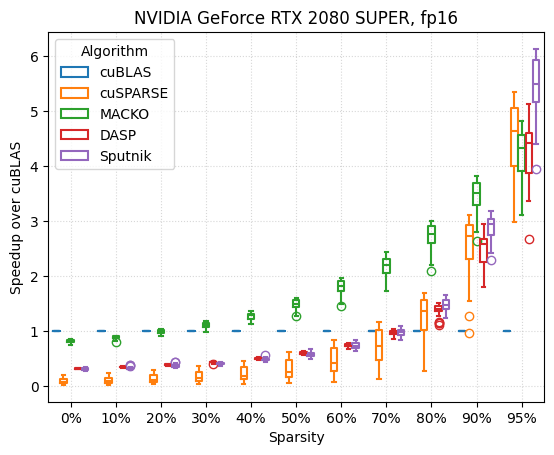

Density 0.1 cuBLAS


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.0
mean,16631.741935,12936.258065,1.0
std,12519.679738,11009.633887,0.0
min,3584.000000,3584.000000,1.0
25%,7168.000000,5120.000000,1.0
50%,12288.000000,9216.000000,1.0
75%,28160.000000,14080.000000,1.0
max,49152.000000,49152.000000,1.0


Density 0.1 cuSPARSE


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,2.545674
std,12519.679738,11009.633887,0.593534
min,3584.000000,3584.000000,0.958899
25%,7168.000000,5120.000000,2.309722
50%,12288.000000,9216.000000,2.736771
75%,28160.000000,14080.000000,2.934568
max,49152.000000,49152.000000,3.119149


Density 0.1 MACKO


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,3.437532
std,12519.679738,11009.633887,0.300251
min,3584.000000,3584.000000,2.636364
25%,7168.000000,5120.000000,3.289617
50%,12288.000000,9216.000000,3.506849
75%,28160.000000,14080.000000,3.693647
max,49152.000000,49152.000000,3.823383


Density 0.1 DASP


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,2.479330
std,12519.679738,11009.633887,0.329412
min,3584.000000,3584.000000,1.808103
25%,7168.000000,5120.000000,2.257176
50%,12288.000000,9216.000000,2.581515
75%,28160.000000,14080.000000,2.673591
max,49152.000000,49152.000000,2.947197


Density 0.1 Sputnik


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,2.874799
std,12519.679738,11009.633887,0.253700
min,3584.000000,3584.000000,2.289474
25%,7168.000000,5120.000000,2.750968
50%,12288.000000,9216.000000,2.954545
75%,28160.000000,14080.000000,3.032400
max,49152.000000,49152.000000,3.186957


Density 0.5 cuBLAS


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.0
mean,16631.741935,12936.258065,1.0
std,12519.679738,11009.633887,0.0
min,3584.000000,3584.000000,1.0
25%,7168.000000,5120.000000,1.0
50%,12288.000000,9216.000000,1.0
75%,28160.000000,14080.000000,1.0
max,49152.000000,49152.000000,1.0


Density 0.5 cuSPARSE


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,0.297097
std,12519.679738,11009.633887,0.178717
min,3584.000000,3584.000000,0.047417
25%,7168.000000,5120.000000,0.169597
50%,12288.000000,9216.000000,0.258065
75%,28160.000000,14080.000000,0.478784
max,49152.000000,49152.000000,0.617391


Density 0.5 MACKO


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,1.480932
std,12519.679738,11009.633887,0.096345
min,3584.000000,3584.000000,1.264706
25%,7168.000000,5120.000000,1.441654
50%,12288.000000,9216.000000,1.494118
75%,28160.000000,14080.000000,1.554791
max,49152.000000,49152.000000,1.601810


Density 0.5 DASP


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,0.599665
std,12519.679738,11009.633887,0.020572
min,3584.000000,3584.000000,0.559736
25%,7168.000000,5120.000000,0.585581
50%,12288.000000,9216.000000,0.597088
75%,28160.000000,14080.000000,0.613588
max,49152.000000,49152.000000,0.638114


Density 0.5 Sputnik


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,0.581437
std,12519.679738,11009.633887,0.044541
min,3584.000000,3584.000000,0.489712
25%,7168.000000,5120.000000,0.547092
50%,12288.000000,9216.000000,0.575410
75%,28160.000000,14080.000000,0.607099
max,49152.000000,49152.000000,0.672878


In [12]:
for target_gpu in ["NVIDIA_GeForce_RTX_4090", "NVIDIA_GeForce_RTX_3090", "NVIDIA_GeForce_RTX_2080_SUPER"]:
    df = load_results(target_gpu)
    draw_speedup_over_all_sizes(df, target_gpu)

NVIDIA GeForce RTX 4090, fp16, 4096x4096, cuBLAS runtime 59 $\mu s$
 
\begin{figure}[H]
    \centering
    \includegraphics[width=\textwidth]{paper/fp16_NVIDIA_GeForce_RTX_4090_4096_4096_relative_speedup.pdf}
    \caption{Speedup of MACKO relative to cuBLAS on NVIDIA GeForce RTX 4090 for 4096x4096, cuBLAS runtime 59 $\mu s$.}
    \label{appendix_speedup:NVIDIA_GeForce_RTX_4090:4096:4096}
\end{figure}



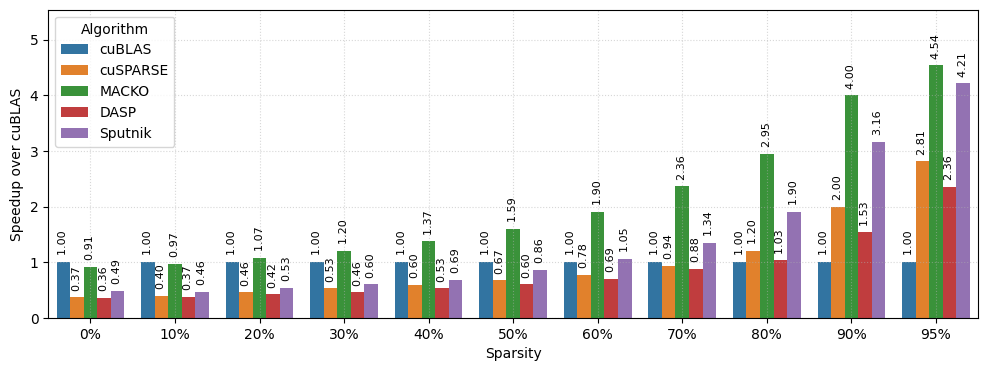

NVIDIA GeForce RTX 4090, fp16, 4096x11008, cuBLAS runtime 122 $\mu s$
 
\begin{figure}[H]
    \centering
    \includegraphics[width=\textwidth]{paper/fp16_NVIDIA_GeForce_RTX_4090_4096_11008_relative_speedup.pdf}
    \caption{Speedup of MACKO relative to cuBLAS on NVIDIA GeForce RTX 4090 for 4096x11008, cuBLAS runtime 122 $\mu s$.}
    \label{appendix_speedup:NVIDIA_GeForce_RTX_4090:4096:11008}
\end{figure}



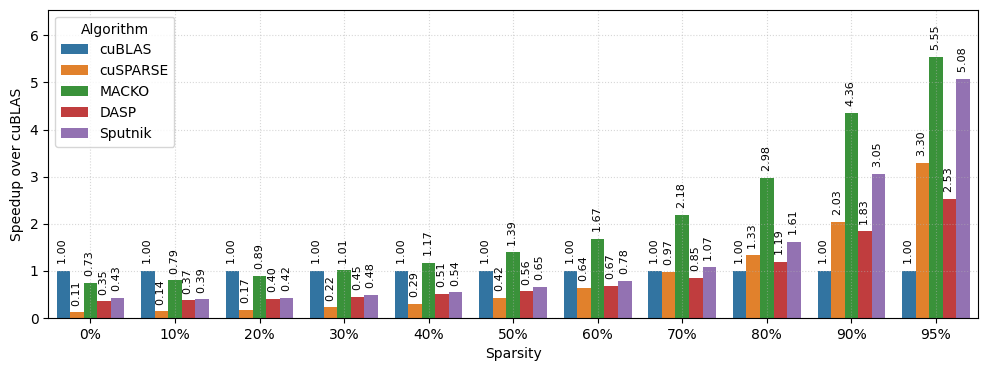

NVIDIA GeForce RTX 4090, fp16, 11008x4096, cuBLAS runtime 120 $\mu s$
 
\begin{figure}[H]
    \centering
    \includegraphics[width=\textwidth]{paper/fp16_NVIDIA_GeForce_RTX_4090_11008_4096_relative_speedup.pdf}
    \caption{Speedup of MACKO relative to cuBLAS on NVIDIA GeForce RTX 4090 for 11008x4096, cuBLAS runtime 120 $\mu s$.}
    \label{appendix_speedup:NVIDIA_GeForce_RTX_4090:11008:4096}
\end{figure}



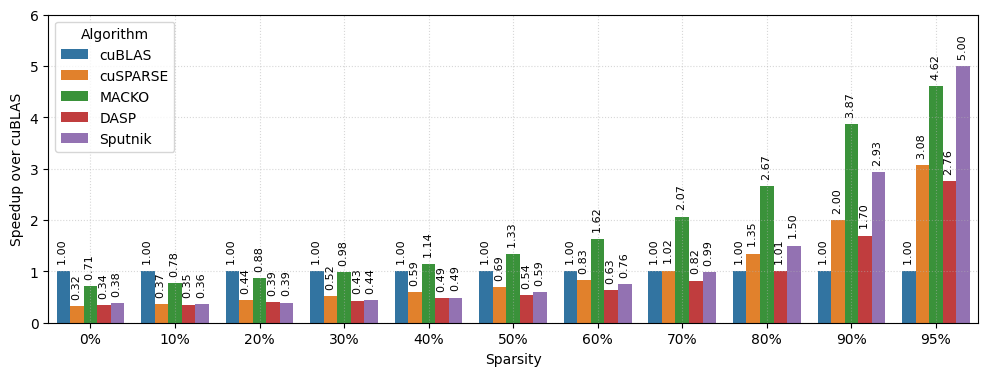

NVIDIA GeForce RTX 4090, fp16, 12288x12288, cuBLAS runtime 336 $\mu s$
 
\begin{figure}[H]
    \centering
    \includegraphics[width=\textwidth]{paper/fp16_NVIDIA_GeForce_RTX_4090_12288_12288_relative_speedup.pdf}
    \caption{Speedup of MACKO relative to cuBLAS on NVIDIA GeForce RTX 4090 for 12288x12288, cuBLAS runtime 336 $\mu s$.}
    \label{appendix_speedup:NVIDIA_GeForce_RTX_4090:12288:12288}
\end{figure}



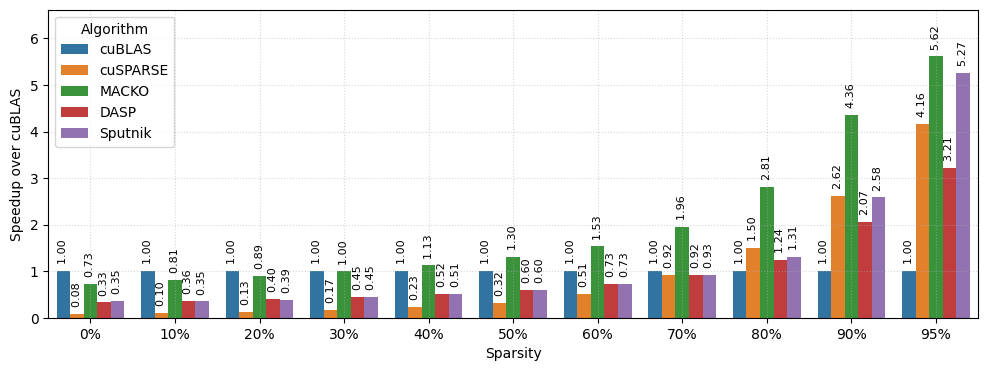

NVIDIA GeForce RTX 3090, fp16, 4096x4096, cuBLAS runtime 54 $\mu s$
 
\begin{figure}[H]
    \centering
    \includegraphics[width=\textwidth]{paper/fp16_NVIDIA_GeForce_RTX_3090_4096_4096_relative_speedup.pdf}
    \caption{Speedup of MACKO relative to cuBLAS on NVIDIA GeForce RTX 3090 for 4096x4096, cuBLAS runtime 54 $\mu s$.}
    \label{appendix_speedup:NVIDIA_GeForce_RTX_3090:4096:4096}
\end{figure}



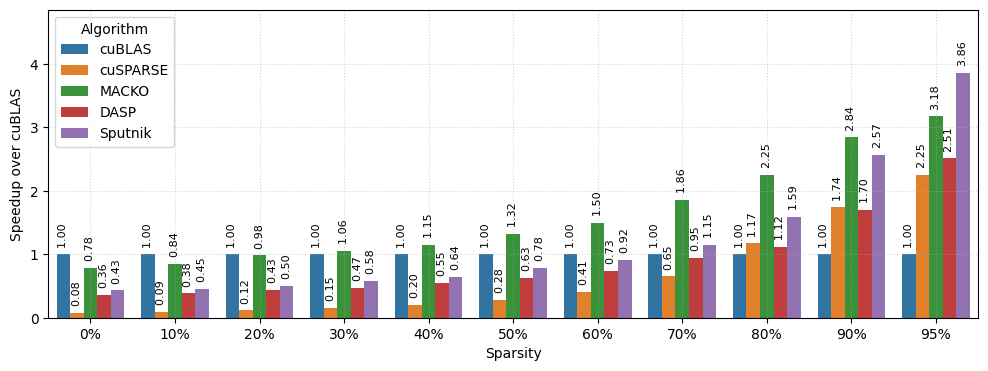

NVIDIA GeForce RTX 3090, fp16, 4096x11008, cuBLAS runtime 121 $\mu s$
 
\begin{figure}[H]
    \centering
    \includegraphics[width=\textwidth]{paper/fp16_NVIDIA_GeForce_RTX_3090_4096_11008_relative_speedup.pdf}
    \caption{Speedup of MACKO relative to cuBLAS on NVIDIA GeForce RTX 3090 for 4096x11008, cuBLAS runtime 121 $\mu s$.}
    \label{appendix_speedup:NVIDIA_GeForce_RTX_3090:4096:11008}
\end{figure}



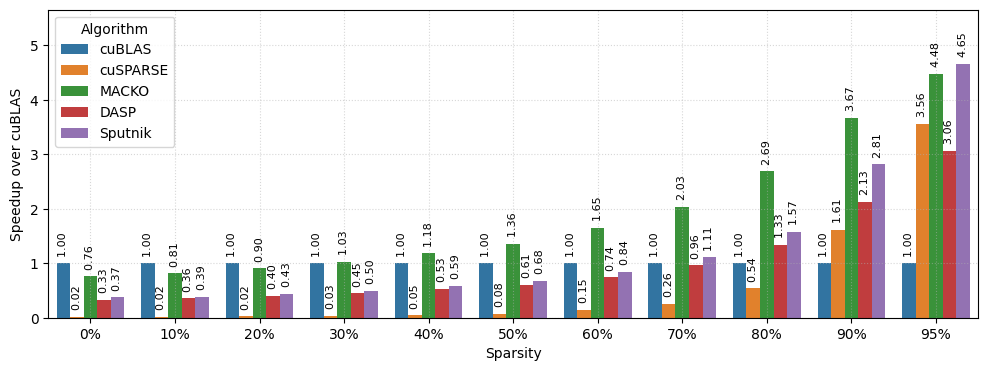

NVIDIA GeForce RTX 3090, fp16, 11008x4096, cuBLAS runtime 134 $\mu s$
 
\begin{figure}[H]
    \centering
    \includegraphics[width=\textwidth]{paper/fp16_NVIDIA_GeForce_RTX_3090_11008_4096_relative_speedup.pdf}
    \caption{Speedup of MACKO relative to cuBLAS on NVIDIA GeForce RTX 3090 for 11008x4096, cuBLAS runtime 134 $\mu s$.}
    \label{appendix_speedup:NVIDIA_GeForce_RTX_3090:11008:4096}
\end{figure}



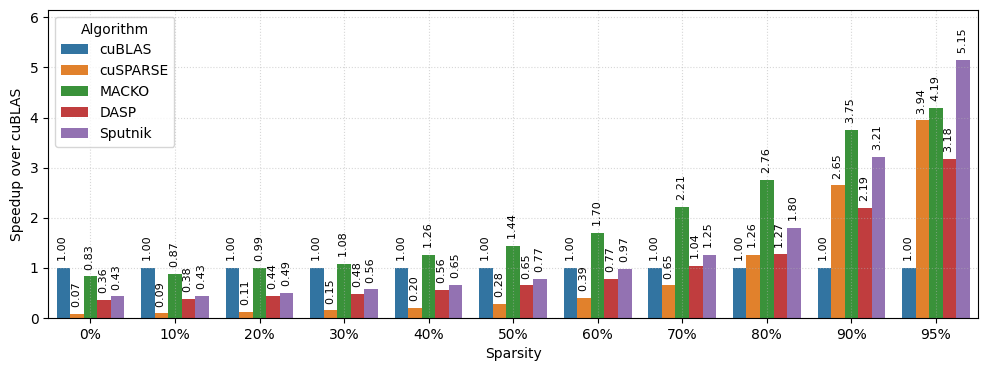

NVIDIA GeForce RTX 3090, fp16, 12288x12288, cuBLAS runtime 397 $\mu s$
 
\begin{figure}[H]
    \centering
    \includegraphics[width=\textwidth]{paper/fp16_NVIDIA_GeForce_RTX_3090_12288_12288_relative_speedup.pdf}
    \caption{Speedup of MACKO relative to cuBLAS on NVIDIA GeForce RTX 3090 for 12288x12288, cuBLAS runtime 397 $\mu s$.}
    \label{appendix_speedup:NVIDIA_GeForce_RTX_3090:12288:12288}
\end{figure}



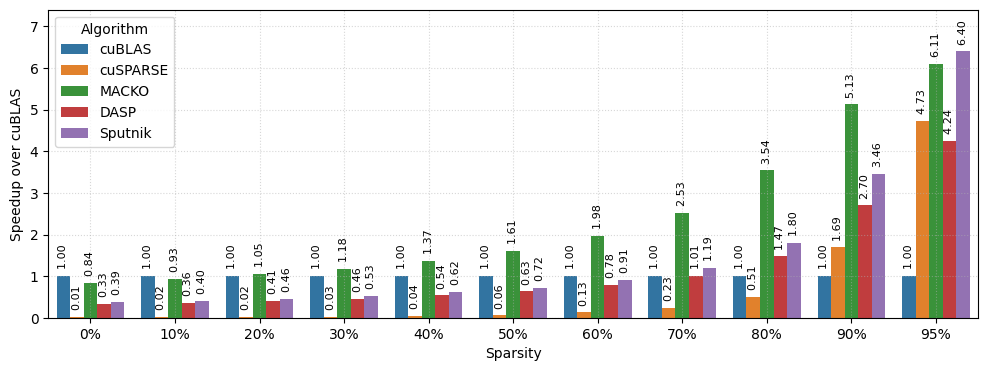

NVIDIA GeForce RTX 2080 SUPER, fp16, 4096x4096, cuBLAS runtime 86 $\mu s$
 
\begin{figure}[H]
    \centering
    \includegraphics[width=\textwidth]{paper/fp16_NVIDIA_GeForce_RTX_2080_SUPER_4096_4096_relative_speedup.pdf}
    \caption{Speedup of MACKO relative to cuBLAS on NVIDIA GeForce RTX 2080 SUPER for 4096x4096, cuBLAS runtime 86 $\mu s$.}
    \label{appendix_speedup:NVIDIA_GeForce_RTX_2080_SUPER:4096:4096}
\end{figure}



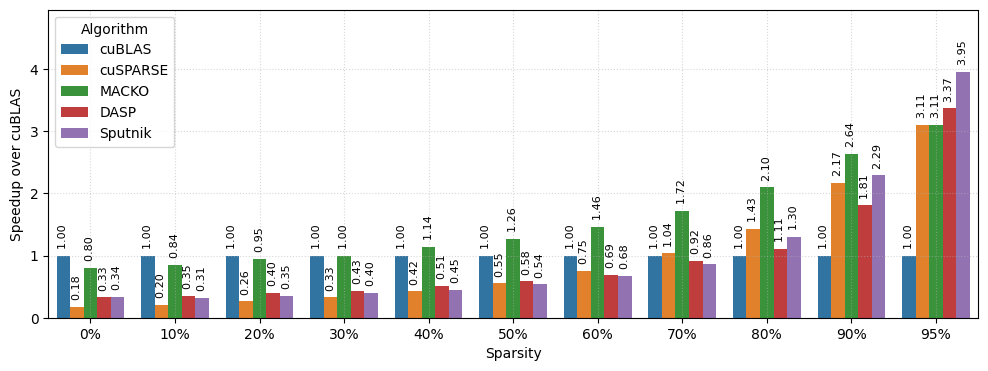

NVIDIA GeForce RTX 2080 SUPER, fp16, 4096x11008, cuBLAS runtime 223 $\mu s$
 
\begin{figure}[H]
    \centering
    \includegraphics[width=\textwidth]{paper/fp16_NVIDIA_GeForce_RTX_2080_SUPER_4096_11008_relative_speedup.pdf}
    \caption{Speedup of MACKO relative to cuBLAS on NVIDIA GeForce RTX 2080 SUPER for 4096x11008, cuBLAS runtime 223 $\mu s$.}
    \label{appendix_speedup:NVIDIA_GeForce_RTX_2080_SUPER:4096:11008}
\end{figure}



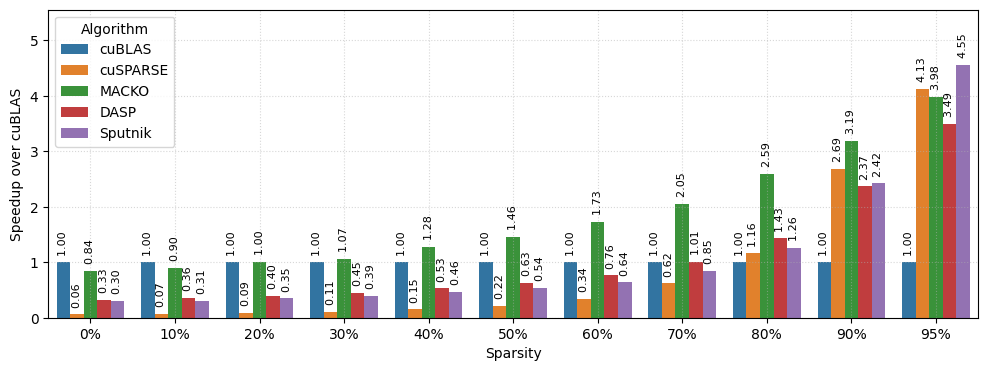

NVIDIA GeForce RTX 2080 SUPER, fp16, 11008x4096, cuBLAS runtime 211 $\mu s$
 
\begin{figure}[H]
    \centering
    \includegraphics[width=\textwidth]{paper/fp16_NVIDIA_GeForce_RTX_2080_SUPER_11008_4096_relative_speedup.pdf}
    \caption{Speedup of MACKO relative to cuBLAS on NVIDIA GeForce RTX 2080 SUPER for 11008x4096, cuBLAS runtime 211 $\mu s$.}
    \label{appendix_speedup:NVIDIA_GeForce_RTX_2080_SUPER:11008:4096}
\end{figure}



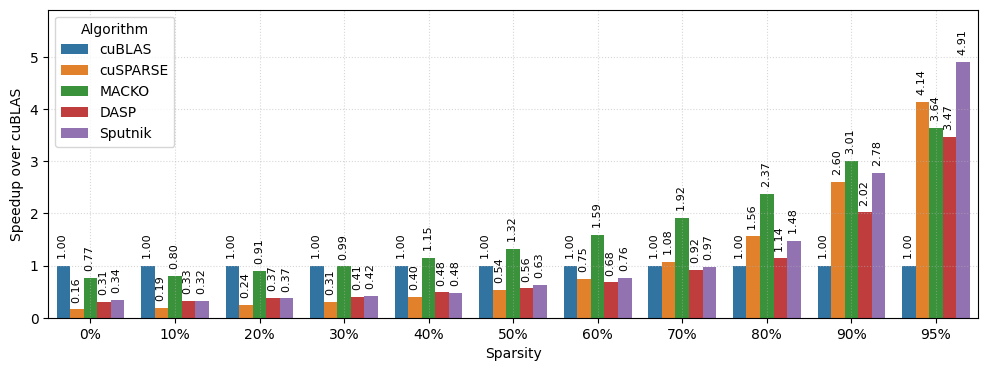

NVIDIA GeForce RTX 2080 SUPER, fp16, 12288x12288, cuBLAS runtime 708 $\mu s$
 
\begin{figure}[H]
    \centering
    \includegraphics[width=\textwidth]{paper/fp16_NVIDIA_GeForce_RTX_2080_SUPER_12288_12288_relative_speedup.pdf}
    \caption{Speedup of MACKO relative to cuBLAS on NVIDIA GeForce RTX 2080 SUPER for 12288x12288, cuBLAS runtime 708 $\mu s$.}
    \label{appendix_speedup:NVIDIA_GeForce_RTX_2080_SUPER:12288:12288}
\end{figure}



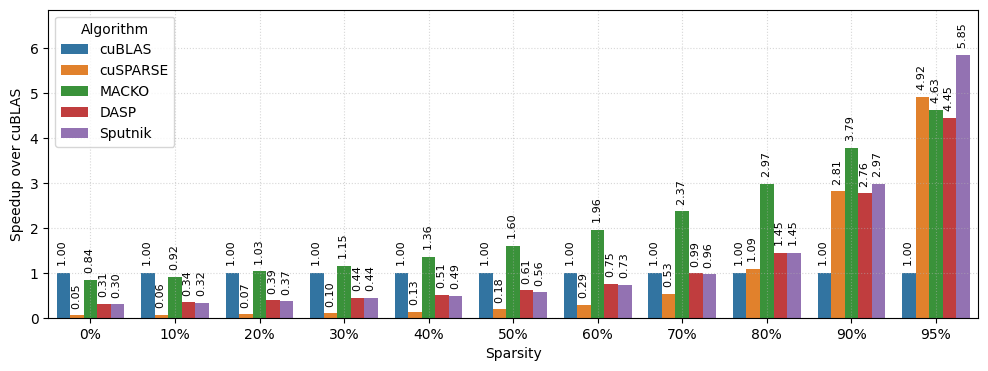

In [13]:
# Only regenerate this when needed.
gpus = ["NVIDIA_GeForce_RTX_4090", "NVIDIA_GeForce_RTX_3090", "NVIDIA_GeForce_RTX_2080_SUPER"]
shapes = [
    [4096,4096],
    [4096,11008],
    [11008,4096],
    [12288,12288],
]
for target_gpu in gpus: 
    df = load_results(target_gpu)
    for shape in shapes:
        draw_speedup_bar(df, target_gpu, shape, to_paper=True)

In [14]:
shapes = [
    [4096,4096],
    [8192,8192],
    [8192,29568],
    [32000,5120],
    [32000,8192],
    [28672,8192],
    [5120,5120],
    [5120,13824],
    [3584,20480],
    [4096,11008],
    [13824,5120],
    [18944,3584],
    [14336,4096],
    [4096,14336],
    [8192,28672],
    [11008,4096],
    [32000,4096],
    [20480,3584],
    [3584,18944],
    [21504,7168],
    [7168,7168],
    [28672,7168],
    [7168,28672],
    [27648,9216],
    [9216,9216],
    [36864,9216],
    [9216,36864],
    [36864,12288],
    [12288,12288],
    [49152,12288],
    [12288,49152],
]
gpus = ["NVIDIA_GeForce_RTX_4090", "NVIDIA_GeForce_RTX_3090", "NVIDIA_GeForce_RTX_2080_SUPER"]

for target_gpu in gpus: 
    df = load_results(target_gpu)
    for shape in shapes:
        draw_speedup_bar(df, target_gpu, shape)
        clear_output()